# VMT and Demographics
*Created by Felicia Freeman & Aaron Barrall*
***
Our research project aims to examine the demography of both low and high VMT areas in
San Diego County. Who lives in these tracts? Is there a difference between the
residents of high VMT tracts closer to the central business district and those
who live at the edges of urbanized places? Who might benefit from building or limiting
new housing there?


We hypothesize that VMT is negatively associated with various demographic factors,
including minority percentage of the population, income, and percent households that are
renters.

***
### Background & Motivation
California’s state legislature has recently passed several laws which promote new housing production in urbanized areas (e.g. SB 9, SB 35, SB 828), as well as changed the review process for transportation impacts to assist in meeting California’s climate goals **(SB 743)**. These laws ultimately streamline development in some areas, while **increasing the barriers to development** in others, especially those with **high average Vehicle Miles Traveled (VMT)**.

The California Governor’s Office of Planning and Research has suggested that projects located in neighborhoods with 85% or less of the comparison VMT (either local, subregional, or regional) should be eligible for streamlined Transportation related CEQA analysis. Many projects in areas above 85% of the VMT threshold are expected to implement mitigation measures to reduce the site-specific land-use project impacts on VMT. For some projects, the cost to “mitigate” VMT impacts may be time and cost prohibitive, unless local agencies allow for creative offsite mitigation measures or adopt other thresholds.

Infill development is a wise choice at a state or regional level, but screening projects based on limited criteria, such as whether a project is in a “low VMT area” may stifle much-needed housing development. Preventing new growth in “high VMT'' areas has the potential to increase segregation within inner-ring enclaves by creating barriers to building new housing under the guise of environmental protection, while simultaneously inhibiting economic opportunity in more rural or exurban communities.

Recently, the San Diego County Board of Supervisors voted to use the regional VMT average when analyzing projects under CEQA, ostensibly as a way to reduce VMT and greenhouse gas emissions. This project studies VMT patterns by demographics in San Diego County to understand the potential equity implications of the use of the Regional Average as a threshold. 

Specifically, we examine the relationship of racial demographics, income, and housing tenure by VMT. We use **summary statistics**, **K-Means Clustering**, and **linear regression** to show that **lower VMT census tracts have lower median incomes, are disproportionately renters, and have a larger percentage of minority residents than “high VMT” census tracts**. 
***

###  Core Strategies we learned in URB PLN 229!

* API Calls for the US Census
* Joining
* Text Parsing and Splitting
* Spatial Joins
* K-Means Cluster Analysis
* Mapping
* Regression (Linear + Logistic)
***

In [39]:
#Load packages we need.

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import cenpy
from cenpy import products
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [40]:
#Load in the SANDAG Database.
sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/San_Diego_Region_SB743_VMT_Maps.shp') 

## Subsetting our data. 

We are concerned about data on the Census Tract level, for the estimated year 2025, using the most recently developed SANDAG model. We also subset for residents and VMT per capita to best match SB 743. 

In [41]:
gdf = sandagvmt[(sandagvmt['geo']=='Census Tract') & (sandagvmt['vmt_year']==2025) & (sandagvmt['version']=='ABM2+ / 2021 RP')&(sandagvmt['vmt_type']=='Residents') & (sandagvmt['vmt_metric']=='Per Capita')]

## Collect Census Data
We are using the Census API because of issues with cenpy. We are reading in variables concerning population, race, household income, and renter status. We created new columns for percentages of these relevant demographic variables. 

In [42]:
import requests
r = requests.get('https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E,B25003_001E,B25003_003E&for=tract&in=state:06+county:073')
censusdata = r.json()
df=pd.DataFrame(censusdata[1:], columns=censusdata[0])
ca=df[df['state']=='06']
sd=ca[ca['county']=='073']
sd.head()

,NAME,B01001_001E,B01001H_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E,B25119_001E,B25003_001E,B25003_003E,state,county,tract
0,"Census Tract 165.04, San Diego County, California",6856,3138,6856,601,121,442,0,58,352,2144,46440,2511,1956,06,073,016504
1,"Census Tract 170.51, San Diego County, California",5188,2914,5188,346,0,737,168,0,448,575,106161,1988,765,06,073,017051
2,"Census Tract 170.53, San Diego County, California",3305,2552,3305,3,0,198,0,0,256,296,155208,1061,70,06,073,017053
3,"Census Tract 170.54, San Diego County, California",5731,4209,5731,82,9,370,0,0,252,809,101875,1874,455,06,073,017054
4,"Census Tract 170.52, San Diego County, California",5277,2629,5277,0,21,1530,23,150,267,657,103336,2221,1184,06,073,017052


In [43]:
sd.rename(columns={"B01001_001E":"total_pop","B01001H_001E":"white_nh","B25119_001E": "median_income", "B03002_001E": "total_race","B03002_004E":"black_nh", "B03002_005E":"native_na_alaska_nh","B03002_006E":"asian_nh","B03002_007E":"native_hi_pi_nh","B03002_008E":"other_race","B03002_009E":"mixed_race","B03002_012E": "total_hisp","B25003_001E":"total_housing", "B25003_003E":"total_renters"}, inplace=True)

sd['pc_nonHispanicWhite'] = sd.white_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_Black'] = sd.black_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_amindian'] = sd.native_na_alaska_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_pacislander'] = sd.native_hi_pi_nh.astype(float) / sd.total_pop.astype(float) * 100
sd['pc_asian'] = sd.asian_nh.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_mixedrace'] = sd.mixed_race.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_hispanic'] = sd.total_hisp.astype(float) / sd.total_pop.astype(float) * 100 
sd['pc_other_race'] = sd.other_race.astype(float) / sd.total_pop.astype(float) * 100 

sd['pc_renter'] = sd.total_renters.astype(float) / sd.total_housing.astype(float) * 100


## Prepping for Join

Because we can't use cenpy, and because the SANDAG database does not have a GEOID Field, we need to load the tracts in with geometry.

In [44]:
censustractsGDF = sandagvmt=gpd.read_file('San_Diego_Region_SB743_VMT_Maps/tl_2019_06_tract.shp') #Load in the Tracts with geometry so we can Database.
censustractsGDF = censustractsGDF[(censustractsGDF['COUNTYFP']=='073')]
sd['namesplit'] = sd['NAME'].str.split(',',expand=True,n=1)[0] #Split the name so we can join!

### The Join

In [45]:
censustractsGDF = censustractsGDF.merge(sd,left_on='NAMELSAD',right_on='namesplit') #Join the Census Data to the Tract Geo information.
censustractsGDF = censustractsGDF.to_crs('EPSG:2230')
#set the tract geometry to the centroids
censustractsGDF.geometry =censustractsGDF.representative_point() 

#create the spatial join #Spatial Join the SANDAG and Census Data!
joinDf=gpd.sjoin(gdf,censustractsGDF,how='left',predicate='intersects') 

In [46]:
joinDf['median_income'] =joinDf['median_income'].astype('float64') #Fix Median Income and Remove outliers with negative values
joinDf = joinDf[joinDf['median_income']>0]

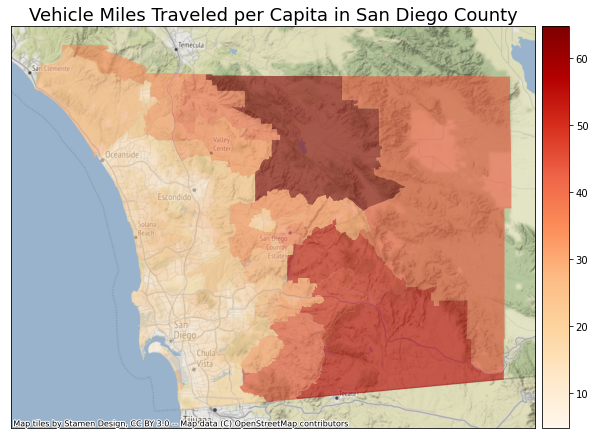

In [47]:
# VMT Map
fig,ax = plt.subplots(figsize = (10,10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) # Reference: https://geopandas.org/en/stable/docs/user_guide/mapping.html
joinDf.plot('vmt_per_ca',  cmap='OrRd', legend=True,ax=ax,alpha=0.6,cax=cax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Vehicle Miles Traveled per Capita in San Diego County',fontsize=18)
ctx.add_basemap(ax,crs=2230)

***
From the map above, we can see that the rural outlying tracts have the highest VMT, as expected. We can also see that some of the lowest VMT areas are in central San Diego, south of I-8, Chula Vista, National City, Pacific Beach, Central Escondido, and Downtown Vista.

This is further illustrated by the next map, which shows that nearly all of the areas lower than the mean are located in the southernmost part of the County. Many of the areas above the regional mean, represented by white and red on the map, are in wealthy areas, such as Del Mar, Rancho Santa Fe, and Poway. 
***

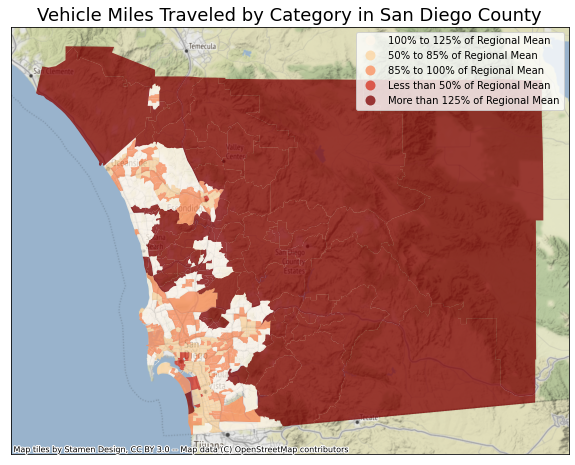

In [48]:
#VMT Category Map
fig0,ax0 = plt.subplots(figsize = (10,10))
joinDf.plot('map_legend',cmap='OrRd', legend=True,ax=ax0,alpha=0.75)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Vehicle Miles Traveled by Category in San Diego County',fontsize=18)
ctx.add_basemap(ax0,crs=2230)

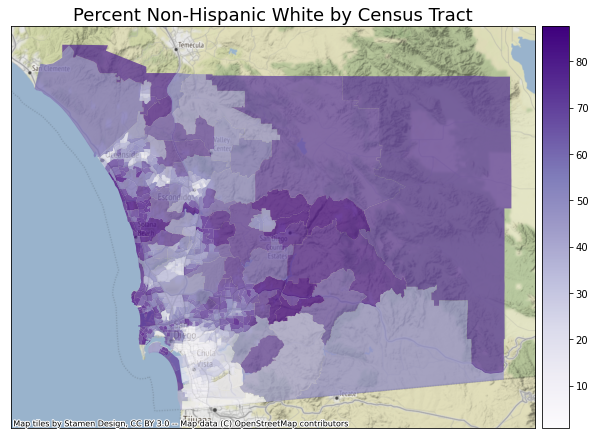

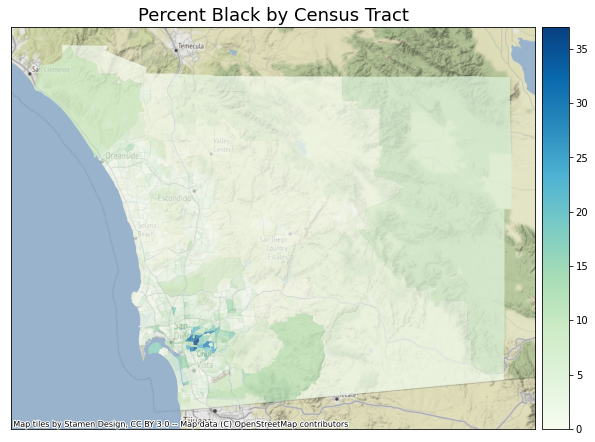

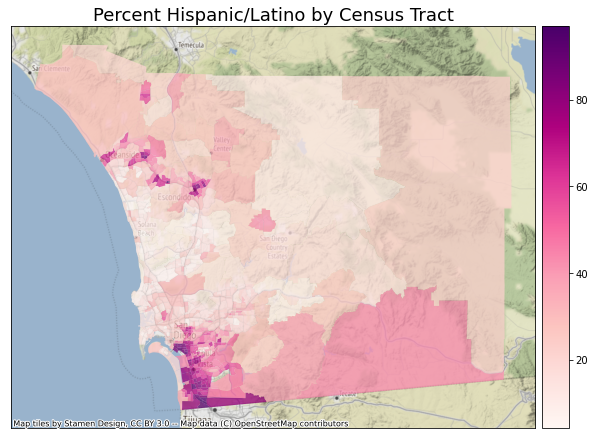

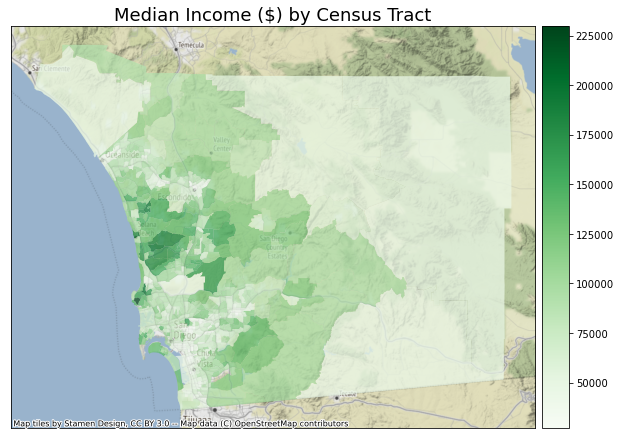

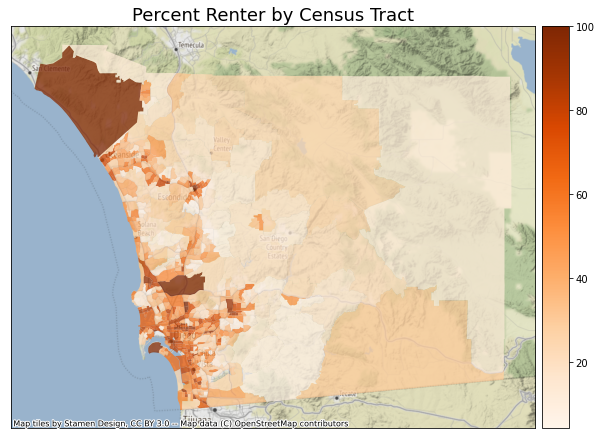

In [49]:
# Demographics Maps 
# Percent White
fig,ax = plt.subplots(figsize = (10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = joinDf.plot('pc_nonHispanicWhite',cmap='Purples',legend=True,cax=cax,ax=ax,alpha=.75)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Percent Non-Hispanic White by Census Tract',fontsize=18)
ctx.add_basemap(ax,crs=2230)

#Percent Black
fig,ax = plt.subplots(figsize = (10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = joinDf.plot('pc_Black',cmap='GnBu',legend=True,cax=cax,ax=ax,alpha=.75)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Percent Black by Census Tract',fontsize=18)
ctx.add_basemap(ax,crs=2230)

#Percent Hispanic/Latino
fig,ax = plt.subplots(figsize = (10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = joinDf.plot('pc_hispanic',cmap='RdPu',legend=True,cax=cax,ax=ax,alpha=.75)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Percent Hispanic/Latino by Census Tract',fontsize=18)
ctx.add_basemap(ax,crs=2230)

#Median Income
fig,ax = plt.subplots(figsize = (10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = joinDf.plot('median_income',cmap='Greens',legend=True,cax=cax,ax=ax,alpha=.75)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Median Income ($) by Census Tract',fontsize=18)
ctx.add_basemap(ax,crs=2230)

#Percent Renter
fig,ax = plt.subplots(figsize = (10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = joinDf.plot('pc_renter',cmap='Oranges',legend=True,cax=cax,ax=ax,alpha=.75)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Percent Renter by Census Tract',fontsize=18)
ctx.add_basemap(ax,crs=2230)

## Boxplots and Scatter Plots for Demographics and VMT!


### Boxplots
***

Text(0.5, 1.0, 'Renter Status by Percentage VMT')

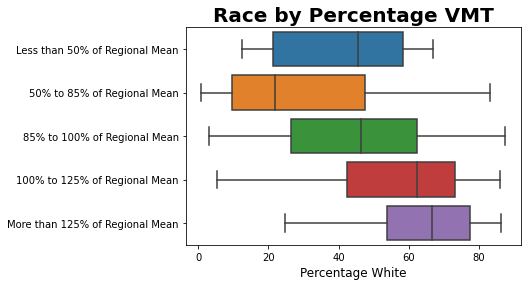

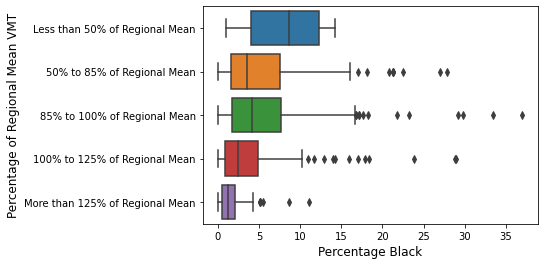

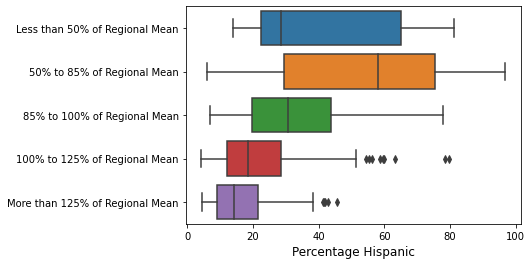

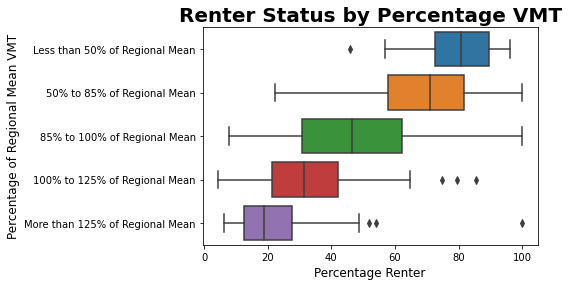

In [50]:
fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_nonHispanicWhite',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage White', size='large')
plt.ylabel('', size='large')
plt.title("Race by Percentage VMT", weight='bold', fontsize=20)

fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_Black',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage Black', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')

fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_hispanic',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage Hispanic', size='large')
plt.ylabel('', size='large')

fig, ax=plt.subplots(1)
ax = sns.boxplot(y='map_legend', x='pc_renter',data=joinDf, order=["Less than 50% of Regional Mean", "50% to 85% of Regional Mean", "85% to 100% of Regional Mean","100% to 125% of Regional Mean","More than 125% of Regional Mean"])

plt.xlabel('Percentage Renter', size='large')
plt.ylabel('Percentage of Regional Mean VMT', size='large')
plt.title("Renter Status by Percentage VMT", weight='bold', fontsize=20)

***
These box plots along with the previous spatial maps of demographics display clear relationships between race, renter status, and VMT. In areas with higher VMT, less residents are renters, hispanic, and Black. Conversely, these areas are more white. Further relationships emerge when looking at areas in San Diego closer to downtown as opposed to in rural areas or suburbs.
***

### Scatterplots and Regression Models
***

Text(0.5, 1.0, 'For Census Tracts in San Diego County')

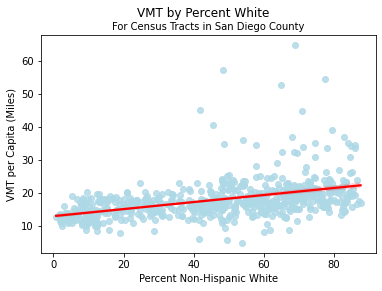

In [51]:
import seaborn as sns
ax = sns.regplot(x="pc_nonHispanicWhite", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'}) #Not a huge relation #Aaron to clean up.
plt.xlabel('Percent Non-Hispanic White')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent White')
plt.title('For Census Tracts in San Diego County',fontsize=10)


Text(0.5, 1.0, 'For Census Tracts in San Diego County')

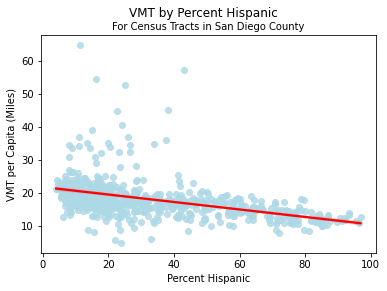

In [52]:
ax = sns.regplot(x="pc_hispanic", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'}) #Not a huge relation
plt.xlabel('Percent Hispanic')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent Hispanic')
plt.title('For Census Tracts in San Diego County',fontsize=10)


Text(0.5, 1.0, 'For Census Tracts in San Diego County')

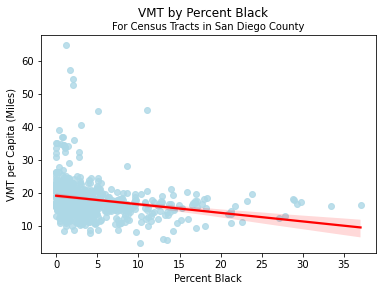

In [53]:
ax = sns.regplot(x="pc_Black", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'})
plt.xlabel('Percent Black')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent Black')
plt.title('For Census Tracts in San Diego County',fontsize=10)

Text(0.5, 1.0, 'For Census Tracts in San Diego County')

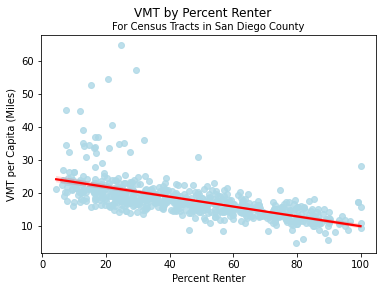

In [54]:
ax = sns.regplot(x="pc_renter", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'})
plt.xlabel('Percent Renter')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Percent Renter')
plt.title('For Census Tracts in San Diego County',fontsize=10)

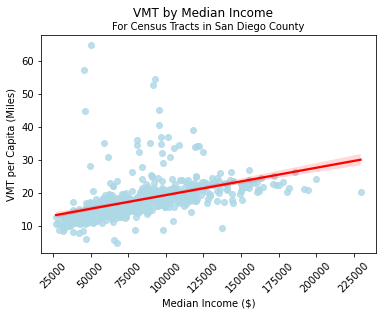

In [55]:
ax = sns.regplot(x="median_income", y="vmt_per_ca", data=joinDf,scatter_kws={'color':'lightblue'},line_kws={'color':'red'})
plt.xlabel('Median Income ($)')
plt.ylabel('VMT per Capita (Miles)')
plt.suptitle('VMT by Median Income')
plt.title('For Census Tracts in San Diego County',fontsize=10)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)



***
These scatterplots support similar conclusions, as well as introduce income as a variable. Areas with higher VMT per capita are richer and whiter, with fewer renters.

Next, we wanted to see how effective some machine learning models would be at predicting different measures of VMT in San Diego. Firstly, we fit a logistic regression model, which takes a number of continuous input variables to predict a categorical outcome variable. In this case, we examined demographic variables and other measures of VMT to predict a given tract's relationship to the mean VMT in the region.
***

#### Logistic Regression - Machine Learning Model

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#adding more predictor variables
xvars = ['vmt','vmt_per_ca','median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']
yvar = 'map_legend' #The VMT Percent Category

df_to_fit = joinDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

In [57]:
LR =LogisticRegression(multi_class='multinomial', solver = "lbfgs", max_iter = 10000)

#fitting the model
LR.fit(X_train, y_train)

#this is a preliminary test on the accuracy of the model, based only on the training set. 
cross_val_score(LR, X_train, y_train, cv=5).mean()

0.6607059373539037

In [58]:
#this confusion matrix plots the actual vs predicted values of our model.
y_test_predictions = LR.predict(X_test)
from sklearn.metrics import confusion_matrix
LR_confusion = confusion_matrix(y_test, y_test_predictions)
LR_confusion

array([[27,  2, 11,  0,  5],
       [ 0, 30,  4,  0,  0],
       [15, 12, 18,  0,  0],
       [ 1,  3,  0,  0,  0],
       [ 7,  0,  4,  0, 16]])

In [59]:
LR.score(X_test,y_test)

0.5870967741935483

***
Overall, the model predicts the correct map category about 60% of the time using our chosen demographic variables. It made about 30 errors, as demonstrated in the confusion matrix. A categorical variable for VMT may not have beeen the best measure of success on a machine learning model. So we are going to look at a continuous model to see how accurate a model can be. 
***

#### Linear Regression

In [60]:
import statsmodels.api as sm

yvar = joinDf['vmt_per_ca']
xvars = joinDf[['median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']]
x=sm.add_constant(xvars)

linearModel = sm.OLS(yvar,xvars).fit()
print(linearModel.summary())

                                 OLS Regression Results                                
Dep. Variable:             vmt_per_ca   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              1495.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):                        0.00
Time:                        22:11:06   Log-Likelihood:                         -1895.0
No. Observations:                 618   AIC:                                      3800.
Df Residuals:                     613   BIC:                                      3822.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

***
We used an ordinary least squares regression to evaluate the effect of different demographic variables on VMT per capita. We controlled for median income, white population, Black population, hispanic population, and renter population for each census tract. Each of these variables had a significant association with VMT. Interestingly, percent of a tract that was hispanic and Black were positively associated with VMT while controlling for the other variables. Percent renter had a negative association, and income had a very small, albeit statistically significant positive correlation. This illustrates that some of the apparent negative correlation shown in the graphs above can be partially explained by the percentage of renters in the housing tract. This may indicate some multi-collinearity in the independent variables we selected. 

***

In [61]:
#LINEAR REGRESSION - machine learning model
from sklearn.linear_model import LinearRegression
xvars = ['median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']
yvar = 'vmt_per_ca'

df_to_fit = joinDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

LinR = LinearRegression()
  
LinR.fit(X_train, y_train)

y_test_predictions = LinR.predict(X_test)

3.1022649813251157


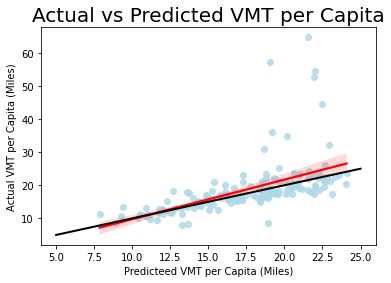

In [69]:
#plotting linear regression model
print(abs(y_test_predictions-y_test).mean())
fig, ax=plt.subplots()
sns.regplot(x=y_test_predictions, y=y_test, scatter_kws={'color':'lightblue'},line_kws={'color':'red'},ax=ax)
plt.xlabel('Predicteed VMT per Capita (Miles)')
plt.ylabel('Actual VMT per Capita (Miles)')
plt.title('Actual vs Predicted VMT per Capita',fontsize=20)
plt.plot([5, 25], [5, 25], color = 'black', linewidth = 2)

***
This linear regression model predicted VMT per capita using purely demographic data. Graphing the predicted values against the actual values of VMT per capita demonstrates the success of this model. The regression line is red, while the black line would be if the model performed perfectly. We can tell that the model is quite accurate in this visualization, barring a few outliers. 
***

## K - Means Cluster Analysis
We decided to perform a cluster analysis to identify any important groupings or hotspots related to VMT and the variables that contribute to it. We represent the outcomes of this model with a radar plot, a spatial mapping of the clusters, and some summary statistics.

In [63]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

joinDf.dropna(inplace=True)

cols_to_plot = ['vmt','vmt_per_ca','total_pop','median_income','pc_nonHispanicWhite','pc_Black','pc_hispanic','pc_renter']

scaler = preprocessing.StandardScaler().fit(joinDf[cols_to_plot])
df_scaled = pd.DataFrame(scaler.transform(joinDf[cols_to_plot]), 
                         columns=cols_to_plot, index=joinDf.index)
df_scaled.dropna(inplace=True)


kmeans = KMeans(n_clusters=8, random_state=1).fit(df_scaled)


joinDf['cluster_id'] = kmeans.labels_

In [64]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [65]:
#code from lecture 15
def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

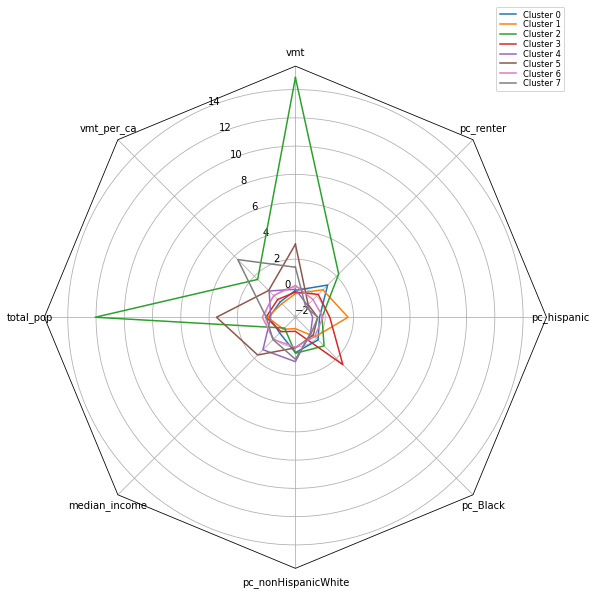

In [66]:
radar_plot(kmeans, df_scaled)

***
We used a K-Value of four in our K-Means analysis. The radar plot illustrates that each cluster had some unique variables that set it apart from the others. 

We experimented with different numbers of clusters until landing on eight. These provided enough variability between groups without too much overlap. While the radar plot is initially helpful in determining which variables are contributing to each cluster, we also wanted to visualize the clusters geographically to infer demographic data ourselves.
***

[]

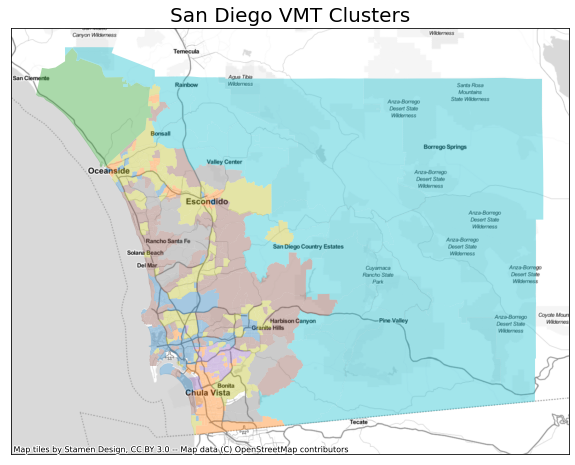

In [70]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))
joinDf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, 
                                   ax=ax, alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('San Diego VMT Clusters', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])


In [68]:
summaryTable = joinDf.groupby('cluster_id')['vmt_per_ca','pc_renter','pc_hispanic','pc_nonHispanicWhite','pc_Black','median_income'].mean()
summaryTable.rename(columns={'vmt_per_ca':'VMT Per Capita','pc_renter':'Renter Percent','pc_hispanic':'Hispanic Percent','pc_nonHispanicWhite':'White Percent','pc_Black':'Black Percent','median_income':'Median Income'})

/var/folders/8n/y7s3wtvx1x19_xxnxrv8njb80000gn/T/ipykernel_41687/1978775590.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summaryTable = joinDf.groupby('cluster_id')['vmt_per_ca','pc_renter','pc_hispanic','pc_nonHispanicWhite','pc_Black','median_income'].mean()


,VMT Per Capita,Renter Percent,Hispanic Percent,White Percent,Black Percent,Median Income
cluster_id,,,,,,
0,14.414474,73.084378,24.413454,56.496491,5.463521,65912.745614
1,13.350800,61.544557,71.392991,14.735535,3.824235,53338.224000
2,27.950000,100.000000,28.572534,57.658564,8.670073,49578.000000
3,15.888542,50.255857,41.295967,19.373612,18.754201,61580.625000
4,20.993125,23.892702,13.070314,72.164635,1.469875,121702.763889
5,21.316667,25.584652,21.201752,48.109074,2.882497,139251.666667
6,18.294564,37.568774,30.092951,47.081338,3.668732,87188.006711
7,39.935909,19.726571,21.764810,68.010911,1.813827,88055.727273


***
### General Analysis of Clusters

**Low VMT, Low Income, and High Minority Cluster.** One cluster was characterized by its relatively high hispanic, renter, and Black population, and a smaller non-hispanic white population, as well as low VMTs and median incomes. Geographically, this cluster is located in the South Bay region, and includes Barrio Logan, Chula Vista, National City, and San Ysidro, areas that were shown to have low VMT in the demographic maps above. It also includes downtown Escondido and Vista, both densely populated and low-income areas.  

The summary statistics show that this area has an average of less than 75% of the regional VMT mean, and is majority hispanic, renter, and low-income. 

**High VMT, High Income, Low Minority Cluster.** The second cluster stands out for its higher percentage of non-hispanic whites, higher median income, and higher VMT. These tracts cover nearly all of unincorporated San Diego County, as well as east county suburbs, like Santee and Poway. Interestingly, this cluster also contains very wealthy coastal areas, like La Jolla, Del Mar, Encinitas, and Carlsbad. The spatial distribution of this cluster suggests that high-income suburbs (even those with good access to public transit and that are located close to commercial amenities) share similarities in VMT with very rural areas. The median income of these tracts is above the regional median: roughly \\$113,000 per household compared to the county median of \\$106,900.

**Very High VMT, High Income Cluster.** The third cluster has a limited number of tracts. It mostly encompasses rural portions of the unincorporated county, and is characterized by an average VMT of 40% above the regional mean. It has a low percent of renters, but also has more minority residents than the other High VMT, High Income cluster. Communities located within this cluster include Campo, Valley Center, and Twin Oaks. Interestingly, it also includes Carmel Valley, a wealthy suburban neighborhood within the City of San Diego, and a stark contrast from the other very rural, agricultural regions. 

**Diverse and Lower VMT Cities/Suburb Cluster.** The last cluster represents the majority of the City of San Diego and its immediate suburbs. This cluster has VMT below the regional mean, a lower median income, and is the most racially diverse of the clusters. This cluster encompases urban neighborhoods, like North Park and Hillcrest, as well as more traditional 1950s tract suburbs, like Mira Mesa, Cairemont Mesa, Lemon Grove, El Cajon, and Oceanside.  This cluster is almost evenly split between renters and owners.  

Overall, these clusters do illustrate a link between VMT and socio-economic status, with the highest VMT clusters being mostly white, high income, and owner-occupied, while the lower VMT tracts had larger minority populations, lower incomes, and mainly renter.
***

## Conclusion
The combination of summary statistics, linear regression, and the K-Means clustering analysis all point to **strong links between demographics and VMT.** In general, tracts with higher non-hispanic white, median incomes, and homeownership had higher VMT. In contrast, tracts with lower VMT (particularly less than 85% of the regional mean) were lower income and had higher minority populations. 

This data illustrates **potential fair housing injustices** by forcing nearly all new housing in “low VMT” neighborhoods. At times where local governments are expected to promote and encourage new housing and streamline construction in areas with high quality transit, they are also required to “affirmatively further fair housing.”  Governments that set their VMT targets too low may hinder overall housing production, and/or force all new development into lower-income neighborhoods that may be highly sensitive to displacement, while leaving sprawling and transit-inefficient neighborhoods intact. The direct association between persons of lower-socioeconomic status and low VMT levels indicates a need for local governments to take a careful and nuanced approach towards setting VMT thresholds, and should consider equity as a key focus, along with climate protection. Avoiding building equity into VMT considerations may allow wealthier, whiter neighborhoods to successfully stifle new housing under the guise of environmental protection. 

***